In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import requests
import sqlite3
import json
import html2text
import re

# from mpl_toolkits.basemap import Basemap
# from matplotlib.patches import Polygon
# from geopy.geocoders import Nominatim
# from geopy.geocoders.base import GeocoderTimedOut
from itertools import product
from lxml import html

http://biogeo.ucdavis.edu/data/gadm2.8/shp/USA_adm_shp.zip

## Get lattice of points in California

In [2]:
topright = (43, -113.924518)
bottomleft = (32.668066, -124.742693)

In [3]:
longs = np.arange(bottomleft[1], topright[1], 0.5)
lats = np.arange(bottomleft[0], topright[0], 0.5)

In [6]:
def plot_lattice(longs = None, lats = None, lattice = None):
    fig = plt.figure(figsize = (13,13))
    m = Basemap(projection='lcc', lat_0=40, lon_0=-110, 
                llcrnrlon=-127, llcrnrlat=30, urcrnrlon=-110, urcrnrlat=45, resolution = "i")
    m.readshapefile('..//data//USA_adm_shp//USA_adm1', name='states', drawbounds=True)

    if lattice == None:
        for coord in product(longs, lats):
            x, y = m(coord[0], coord[1])
            m.plot(x, y, marker = "o", color = "#000000", markersize = 6)
    else:
        for coord in lattice:
            x, y = m(coord[1], coord[0])
            m.plot(x, y, marker = "o", color = "#000000", markersize = 6)        

    for nshape, seg in enumerate(m.states):
        poly = Polygon(seg, edgecolor='b')

    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='#99ffff')
    m.fillcontinents(color='#cc9966', lake_color='#99ffff');

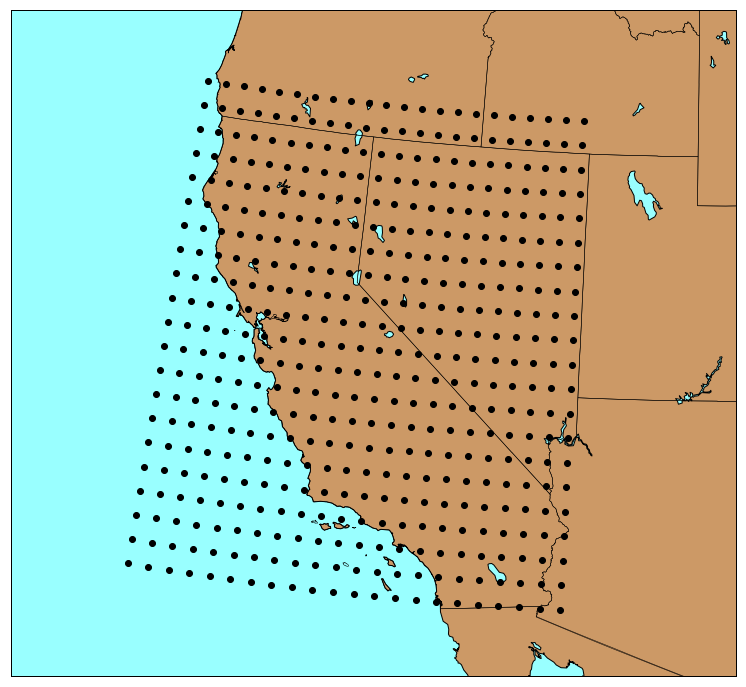

In [5]:
plot_lattice(longs, lats, None)

m(longs, lats)

In [3]:
def sleep_time(base = 1, tolerance = 1):
    
    choose = np.random.uniform(0, 1)
    
    if 0 <= choose <= 0.9:
        return np.random.uniform(base, base + tolerance)
    if 0.9 < choose <= 0.99:
        return np.random.uniform((base + tolerance) * 2, (base + tolerance) * 3)
    else:
        return np.random.uniform((base + tolerance) * 6, (base + tolerance) * 7)

In [3]:
def test_california_lattice_points(lattice_points, coords, geolocator, base, tolerance):
    
    for _ in range(len(coords)):
        
        coord = coords.pop()
        
        location = geolocator.reverse(", ".join(map(str, coord))).raw
        
        # skip point if it is in the sea
        if "error" in location:
            time.sleep(sleep_time(base, tolerance))
            continue
        # another edge case when point is in the sea
        elif "state" not in location["address"]:
            time.sleep(sleep_time(base, tolerance))
            continue            
        # if lattice point is in california, add it
        elif location["address"]["state"] == "California":
            lattice_points.append(coord)
        
        # don't want to violate TOS, wait before searching again
        time.sleep(sleep_time(base, tolerance))

In [8]:
def get_california_lattice(lats, longs, base = 2, tolerance = 2):
    
    geolocator = Nominatim(user_agent="specify_your_app_name_here")
    lattice_points = []

    # don't want to violate TOS: do not search in grid
    coords = list(product(lats, longs))
    np.random.shuffle(coords)
    
    while coords != []:
        print("Testing remaining {} points".format(len(coords)))
        try:
            test_california_lattice_points(lattice_points, coords, geolocator, base = base, tolerance = tolerance)
        except GeocoderTimedOut:
            print("Service timed out")
            print("Currently have {} points left to test".format(len(coords)))
            print()
            time.sleep(10)
        
    return lattice_points

In [9]:
california_lattice = get_california_lattice(lats, longs, base = 3, tolerance = 1)

Testing remaining 462 points
Service timed out
Currently have 351 points left to test

Testing remaining 351 points
Service timed out
Currently have 10 points left to test

Testing remaining 10 points


In [ ]:
plot_lattice(lattice = california_lattice)

## Build SQLite database of dispensaries + deliveries and strain

license_types = ['Adult-Use Cultivation', 'Adult-Use Nonstorefront',
       'Adult-Use Retail', 'Distributor', 'Medical Cultivation',
       'Medical Nonstorefront', 'Medical Retail', 'Microbusiness']

In [2]:
california_lattice = json.load(open("..//data//california_lattice.json", "rb"))

In [3]:
license_types = json.load(open("..//data//license_types.json", "rb"))

In [4]:
def depth(file):
    """
    Finds depth of JSON-formatted file.
    """
    if type(file) == dict:
        for key in file.keys():
            return 1 + max([0] + [depth(file[key])])
    elif type(file) == list:
        for item in file:
            return 1 + max([0] + [depth(item)])
    else:
        return 1

In [30]:
def build_bounding_box(coord, lat_width = 1, long_width = 1):
    """
    coord: A valid coordinate for a specific state. Format is (latitude, longitude)
    """
    lowerleft = (coord[0] - (lat_width / 2), coord[1] - (long_width / 2))
    upperright = (coord[0] + (lat_width / 2), coord[1] + (long_width / 2))
    
    return lowerleft, upperright

def parse_storefronts_in_box(coord):
    """
    coord: one box location.
    """
    
    link = "https://api-g.weedmaps.com/discovery/v1/listings?filter%5Bany_retailer_services%5D%5B%5D=storefront&filter%5Bany_retailer_services%5D%5B%5D=delivery&filter%5Bbounding_box%5D={},{},{},{}&page_size=100&size=2000"
    lowerleft, upperright = build_bounding_box(coord)
    link = link.format(lowerleft[0], lowerleft[1], upperright[0], upperright[1])
    response = requests.get(link).json()["data"]["listings"]
    queries = []
    
    # if there are actually results
    if len(response) > 0:
        
        conn = sqlite3.connect("..//data//weedmaps.db")
        conn.row_factory = sqlite3.Row
        c = conn.cursor()
        
        for result in response:
            
            identity = ""
            if "id" in result:
                identity = result["id"]
                
            name = ""
            if "name" in result:
                name = result["name"]  
                
            state = ""
            if "state" in result:
                state = result["state"]
                
            city = ""
            if "city" in result:
                city = result["city"]

            latitude = ""
            if "latitude" in result:
                latitude = float(result["latitude"])
                
            longitude = ""
            if "longitude" in result:
                longitude = float(result["longitude"])
                
            license_type = ""
            if "license_type" in result:
                license_type = result["license_type"]
                
            address = ""
            if "address" in result:
                address = result["address"]
                
            rating = ""
            if "rating" in result:
                rating = int(result["rating"])
                
            reviews_count = ""
            if "reviews_count" in result:
                reviews_count = int(result["reviews_count"])
                
            zip_code = ""
            if "zip_code" in result:
                zip_code = result["zip_code"]
                
            web_url = ""
            if "web_url" in result:
                web_url = result["web_url"]          
                
            retailer_services = ""
            if "retailer_services" in result:
                retailer_services = result["retailer_services"][0]
                
            slug = ""
            if "slug" in result:
                slug = result["slug"]
                

            
            # at this point, go find the strains, phone number, etc. and add to other database
            phone, license, license_names, email, website = get_metadata(identity, slug, retailer_services, c, conn)
            
            if len(phone) == 0:
                phone = ""
            else:
                phone = phone[0]
            
            temp = [identity, name, state, city, latitude, longitude,
                            license_type, address, rating, reviews_count, zip_code, 
                            web_url, retailer_services, phone, email, website]

            for checker in license_types:
                if checker in license_names:
                    i = license_names.index(checker)
                    temp.append(license[i])
                else:
                    temp.append("")
            
            queries.append(temp)
        
        c.executemany("INSERT OR IGNORE INTO store VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", queries)
        conn.commit()
        conn.close()
        
def get_metadata(identity, slug, retailer_services, c, conn):
    
    """
    This function gets metadata that is not available in the API call.
    It also build the strain database.
    
    identity: ID of the dispensary
    slug: name of dispensary in API
    retailer_services: whether it is a dispensary or a doctor
    c: cursor for database
    """
    
    # build search url
    dis = "https://weedmaps.com/"
    base_link = "https://api-g.weedmaps.com/discovery/v1/listings/"
    if retailer_services == "storefront":
        base_link += "dispensaries/"
        dis += "dispensaries/"
    elif retailer_services == "delivery":
        base_link += "deliveries/"
        dis += "deliveries/"
    base_link += slug + "/"
    menu_items = "menu_items?page={}&page_size=150&limit=150"
    strain_queries = []
                
    check = requests.get(dis + slug)
    tree = html.fromstring(check.content)
    
    # get license, telephone, email, and website
    # get license
    try:
        license = tree.xpath('//*[@id="collapsible-container"]/div[1]/div[1]/ul/li/text()[3]')
        license_name = tree.xpath('//*[@id="collapsible-container"]/div[1]/div[1]/ul/li/text()[1]')
    except:
        license = []
        license_name = []
    
    # telephone
    try:
        telephone = tree.xpath('//*[@id="collapsible-container"]/div[1]/div[1]/div[1]/ul/li[1]/a/text()')
    except:
        telephone = ""
        
    # email
    try:
        email = tree.xpath('//*[@id="collapsible-container"]/div[1]/div[1]/div[1]/ul/li[2]/a/text()')  
    except:
        email = ""
        
    # website
    try:
        website = tree.xpath('//*[@id="collapsible-container"]/div[1]/div[1]/div[1]/ul/li[3]/a/text()')
    except:
        website = ""
        
    #print(license, license_name, telephone, email, website)

    # now that we have ID's, we can now check the menu.
    all_items = requests.get(base_link + menu_items.format(1)).json()
    if "data" in all_items:
        
        num_pages = int(np.ceil(all_items["meta"]["total_menu_items"] / 150))
        
        for page in range(1, num_pages + 1):
            
            total_items = 0
            
            # save some time on page one, reuse the last query
            if page == 1:
                
                for item in all_items["data"]["menu_items"]:

                    # get name of strain
                    name = ""
                    if item["name"] != None:
                        name = item["name"]
                    
                    # get type of strain
                    strain = ""
                    if item["category"]["name"] != None:
                        strain = item["category"]["name"]
                        if strain not in ["Hybrid", "Indica", "Sativa"]:
                            continue
                        total_items += 1
                        
                    # get prices
                    strain_queries = get_prices(strain_queries, item, identity, name, strain)
                    
            #on second page of menu
            else:
                all_items = requests.get(base_link + menu_items.format(page)).json()
                
                for item in all_items["data"]["menu_items"]:
                    
                    # get name of strain
                    name = ""
                    if item["name"] != None:
                        name = item["name"]
                    
                    # get type of strain
                    strain = ""
                    if item["category"]["name"] != None:
                        strain = item["category"]["name"]
                        if strain not in ["Hybrid", "Indica", "Sativa"]:
                            continue
                        total_items += 1
                        
                    # get all prices for each item
                    strain_queries = get_prices(strain_queries, item, identity, name, strain)
        
        c.executemany("INSERT OR IGNORE INTO strain VALUES (?,?,?,?,?,?,?)", strain_queries)
        conn.commit()
    return telephone, license, license_name, email, website
        
def find_stores(lattice, base, tolerance):
    """
    Takes a lattice, finds all stores, and adds to database.
    """
    
    for point in lattice:
        parse_storefronts_in_box(point)
        time.sleep(sleep_time(base, tolerance))

In [31]:
def get_prices(strain_queries, item, identity, name, strain):
    
    if item["prices"] != None:
        
        grams_per_eighth = np.float("inf")
        if "grams_per_eighth" in item["prices"]:
            grams_per_eighth = item["prices"]["grams_per_eighth"]

        # only have grams per eighth
        if len(item["prices"]) == 1:
            strain_queries.append((identity, name, "", "", "", "", grams_per_eighth))

        # looks like this: {'price': 6.0, 'units': '1'} or similar
        elif depth(item["prices"]) == 2:
                for attr in item["prices"]:
                    if attr == "price":
                        price = item["prices"][attr]
                    elif attr == "units":
                        amount = item["prices"][attr]
                        strain_queries.append((identity, name, strain, price, amount, "", grams_per_eighth))

        # looks normal
        else:
            for unit in item["prices"]:
                if unit == "grams_per_eighth":
                    grams_per_eighth = item["prices"]["grams_per_eighth"]
                else:

                    # if there is only one price
                    if type(item["prices"][unit]) == dict:
                        for attr in item["prices"][unit]:
                            if attr == "price":
                                price = item["prices"][unit][attr]
                            elif attr == "units":
                                amount = item["prices"][unit][attr]
                                strain_queries.append((identity, name, strain, price, amount, unit, grams_per_eighth))

                    # if there are multiple pricings
                    elif type(item["prices"][unit]) == list:
                        for pricing in item["prices"][unit]:
                            for attr in pricing:
                                if attr == "price":
                                    price = pricing[attr]
                                elif attr == "units":
                                    amount = pricing[attr]
                                    strain_queries.append((identity, name, strain, price, amount, unit, grams_per_eighth))
    return strain_queries

In [32]:
find_stores(california_lattice, 0, 1)

['A10-18-0000139-TEMP', 'A10-18-0000139-TEMP'] ['Adult-Use Retail', 'Medical Retail'] ['(415) 550-1515'] ['purplestarmd@gmail.com'] ['www.purplestarmd.com']
['C11-18-0000133-TEMP', 'A10-17-0000052-TEMP', 'A10-17-0000052-TEMP'] ['Distributor', 'Adult-Use Retail', 'Medical Retail'] ['(707) 795-1600'] ['info@mercywellness.com'] ['www.mercywellness.com']
['M-10-18-0000155-TEMP', 'A10-18-0000168-TEMP'] ['Medical Retail', 'Adult-Use Retail'] ['1(415) 769-5001'] ['Connectedsf@gmail.com'] ['www.connectedcannabisco.com']
['C10-18-0000064-TEMP', 'C10-18-0000064-TEMP'] ['Adult-Use Retail', 'Medical Retail'] ['(510) 758-7898'] ['info@greenremedycollective.com'] []
['A10-18-0000341-TEMP', 'M10-18-0000201-TEMP'] ['Adult-Use Retail', 'Medical Retail'] ['(707) 652-5018'] ['vhhc420@gmail.com'] ['www.vhhc420.org']
['C9-18-0000115-TEMP'] ['Adult-Use Nonstorefront'] ['510-309-6981'] ['lakesideremedy@gmail.com'] ['www.lakesideremedy.com']
['C9-18-0000085-TEMP'] ['Adult-Use Nonstorefront'] ['4158623686'] ['

KeyboardInterrupt: 

In [9]:
find_stores(california_lattice, 0, 1)

KeyboardInterrupt: 

- {'unit': {'price': 6.0, 'units': '1'}, 'gram': [{'price': 6.0, 'units': '1'}], 'grams_per_eighth': 3.5}
- {'price': 6.0, 'units': '1'}
- {'unit': {'price': 46.0, 'units': '1'}, 'grams_per_eighth': 3.5}

- Check if all the medical and adult-use license are the same
- license table: use license type for column
- store table: use weedmaps as ground truth

In [38]:
find_stores(california_lattice, 5, 2)

on second page +
[(23519, 'Black Water 25.90%', 'Indica', 49.0, '1/8', 'ounce', 3.5), (23519, 'Black Water 25.90%', 'Indica', 95.0, '1/4', 'ounce', 3.5), (23519, 'Black Water 25.90%', 'Indica', 185.0, '1/2', 'ounce', 3.5), (23519, 'Black Water 25.90%', 'Indica', 365.0, '1', 'ounce', 3.5), (23519, 'Blackberry Kush', 'Indica', 29.99, '1/8', 'ounce', 3.5), (23519, 'Blackberry Kush', 'Indica', 55.0, '1/4', 'ounce', 3.5), (23519, 'Blackberry Kush', 'Indica', 105.0, '1/2', 'ounce', 3.5), (23519, 'Blackberry Kush', 'Indica', 200.0, '1', 'ounce', 3.5), (23519, 'Blue Skittlez 25.41%', 'Indica', 16.0, '1', 'gram', 3.5), (23519, 'Blue Skittlez 25.41%', 'Indica', 45.0, '1/8', 'ounce', 3.5), (23519, 'Blue Skittlez 25.41%', 'Indica', 85.0, '1/4', 'ounce', 3.5), (23519, 'Blue Skittlez 25.41%', 'Indica', 165.0, '1/2', 'ounce', 3.5), (23519, 'Blue Skittlez 25.41%', 'Indica', 325.0, '1', 'ounce', 3.5), (23519, 'Cookies - Hi-Octane', 'Indica', 30.0, '1/8', 'ounce', 3.5), (23519, 'Cookies - Hi-Octane', 'I

In [32]:
tmp = requests.get("https://weedmaps.com/dispensaries/natural-healing-center").text
rawtxt = html2text.html2text(tmp)
telephone = re.search("\(tel:.+?\)", rawtxt, flags = re.S).group()

In [42]:
telephone[5:-1]

'805-201-1498'

In [53]:
rawtxt

'Skip to content\n\n[![Weedmaps Logo](/static/images/wm-logo.svg)Weedmaps Home](/)\n\nCancel\n\n[ __Online Order Bag](https://order.weedmaps.com/bag)\n\n[Log In](https://weedmaps.com/login?return_path=%2Fdispensaries%2Fnatural-\nhealing-center)[Sign\nUp](https://weedmaps.com/signup?return_path=%2Fdispensaries%2Fnatural-healing-\ncenter)\n\n[Home ](/)\n\n[Maps ](https://weedmaps.com/listings/in/united-states/california/san-luis-\nobispo)\n\n[Brands ](https://weedmaps.com/brands)\n\n[Deals ](/deals)\n\n[Learn ](https://weedmaps.com/learn)\n\n[News ](https://news.weedmaps.com)\n\nMenu\n\n[![Weedmaps Logo](/static/images/wm-logo-mini.svg)Weedmaps Home](/)\n\nSearch or Update Location\n\n![](https://images.weedmaps.com/dispensaries/000/051/712/avatar/square_fill/1529970944-1529002661-image_missing_copy.jpg?w=140&h=140)\n\n# Natural Healing Center - NHC\n\nFollow\n\n4.3 stars by 100 reviews4.3 (100)\n\n[805-201-1498](tel:805-201-1498)\n\nOpen Now 9:00am - 7:00pm\n\nmedical\n\nrecreational\n\

In [72]:
types = re.search("\(tel:[\s\S]+?Write", rawtxt)#.group()

In [74]:
types.group()

'(tel:805-201-1498)\n\nOpen Now 9:00am - 7:00pm\n\nmedical\n\nrecreational\n\nWrite'

## Obtain individual store's strain data

In [ ]:
def 